In [7]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from pathlib import Path
import timm

In [8]:


train_dir = Path("/content/drive/MyDrive/Colab Notebooks/aihub-meat-image/Training")

image_dirs = [
    train_dir / "[image]cow_seg_1",
    train_dir / "[image]cow_seg_2",
    train_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

data = pd.DataFrame(filepaths, columns=['Filepath'])

data['File ID'] = [Path(filepath).stem.split('_')[-1] for filepath in data['Filepath']]
print(data)


                                               Filepath File ID
0     /content/drive/MyDrive/Colab Notebooks/aihub-m...  001858
1     /content/drive/MyDrive/Colab Notebooks/aihub-m...  002558
2     /content/drive/MyDrive/Colab Notebooks/aihub-m...  001092
3     /content/drive/MyDrive/Colab Notebooks/aihub-m...  001938
4     /content/drive/MyDrive/Colab Notebooks/aihub-m...  003068
...                                                 ...     ...
2994  /content/drive/MyDrive/Colab Notebooks/aihub-m...  008184
2995  /content/drive/MyDrive/Colab Notebooks/aihub-m...  012335
2996  /content/drive/MyDrive/Colab Notebooks/aihub-m...  008423
2997  /content/drive/MyDrive/Colab Notebooks/aihub-m...  010287
2998  /content/drive/MyDrive/Colab Notebooks/aihub-m...  004594

[2999 rows x 2 columns]


In [9]:
import json
from pathlib import Path
import pandas as pd

train_dir = Path("/content/drive/MyDrive/Colab Notebooks/aihub-meat-image/Training")

label_dirs = [
    train_dir / "[label]cow_seg_1",
    train_dir / "[label]cow_seg_2",
    train_dir / "[label]cow_seg_3"
]

points_data = pd.DataFrame(columns=['File ID', 'Points'])

for label_dir in label_dirs:
    # Get all JSON file paths in the label_dir
    json_files = label_dir.glob("*.json")

    for json_file in json_files:
        # Load the JSON file
        with open(json_file, 'r') as f:
            label_json = json.load(f)

        # Extract the points from the label JSON
        points = label_json['label_info']['shapes'][0]['points']
        grade = int(label_json['label_info']['shapes'][0]['grade'])-1

        # Convert the points to a string representation
        points_str = str(points)

        # Extract the last ID from the file name
        file_id = json_file.stem.split('_')[-1]


        # Create a temporary DataFrame with the current data
        temp_df = pd.DataFrame({
            'File ID': [file_id],
            'Points': [points_str],
            'Grade': [grade]
        })

        # Concatenate the temporary DataFrame with the main points_data DataFrame
        points_data = pd.concat([points_data, temp_df], ignore_index=True)

print(points_data)


     File ID                                             Points  Grade
0     000006  [[509.33638443935916, 761.8306636155605], [472...    0.0
1     000010  [[722.1510297482836, 1098.2151029748284], [726...    0.0
2     000008  [[511.33258678611435, 607.9283314669652], [459...    0.0
3     000007  [[632.9061784897024, 876.2471395881006], [573....    0.0
4     000012  [[586.5373961218836, 683.545706371191], [564.3...    0.0
...      ...                                                ...    ...
2995  015924  [[264.8803827751196, 214.02665755297332], [262...    2.0
2996  015907  [[355.6971375807941, 595.8264081255771], [331....    2.0
2997  015941  [[250.52631578947364, 219.0123839009288], [249...    2.0
2998  016018  [[107.96116504854368, 400.62289218191114], [11...    2.0
2999  016050  [[677.9501385041551, 871.9113573407201], [700....    2.0

[3000 rows x 3 columns]


In [10]:
train_data = pd.merge(data, points_data, on='File ID', how='inner')
print(train_data)
train_data.to_csv('train_data.csv')


                                               Filepath File ID  \
0     /content/drive/MyDrive/Colab Notebooks/aihub-m...  001858   
1     /content/drive/MyDrive/Colab Notebooks/aihub-m...  002558   
2     /content/drive/MyDrive/Colab Notebooks/aihub-m...  001092   
3     /content/drive/MyDrive/Colab Notebooks/aihub-m...  001938   
4     /content/drive/MyDrive/Colab Notebooks/aihub-m...  003068   
...                                                 ...     ...   
2994  /content/drive/MyDrive/Colab Notebooks/aihub-m...  008184   
2995  /content/drive/MyDrive/Colab Notebooks/aihub-m...  012335   
2996  /content/drive/MyDrive/Colab Notebooks/aihub-m...  008423   
2997  /content/drive/MyDrive/Colab Notebooks/aihub-m...  010287   
2998  /content/drive/MyDrive/Colab Notebooks/aihub-m...  004594   

                                                 Points  Grade  
0     [[253.31269349845203, 386.0061919504645], [268...    0.0  
1     [[603.157894736842, 679.4508009153318], [577.9...    0.0  


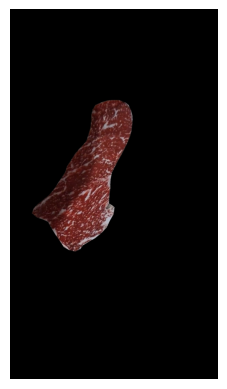

In [12]:
def visualize_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize a specific image by providing its file path
image_path = train_data['Filepath'][1111]  # Replace with the index of the desired image
visualize_image(image_path)

In [13]:
valid_dir = Path("/content/drive/MyDrive/Colab Notebooks/aihub-meat-image/Validation")

image_dirs = [
    valid_dir / "[image]cow_seg_1",
    valid_dir / "[image]cow_seg_2",
    valid_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

valid_data = pd.DataFrame(filepaths, columns=['Filepath'])

valid_data['File ID'] = [Path(filepath).stem.split('_')[-1] for filepath in valid_data['Filepath']]
print(valid_data)


                                               Filepath File ID
0     /content/drive/MyDrive/Colab Notebooks/aihub-m...  069878
1     /content/drive/MyDrive/Colab Notebooks/aihub-m...  070440
2     /content/drive/MyDrive/Colab Notebooks/aihub-m...  069887
3     /content/drive/MyDrive/Colab Notebooks/aihub-m...  070871
4     /content/drive/MyDrive/Colab Notebooks/aihub-m...  071206
...                                                 ...     ...
1495  /content/drive/MyDrive/Colab Notebooks/aihub-m...  076499
1496  /content/drive/MyDrive/Colab Notebooks/aihub-m...  072172
1497  /content/drive/MyDrive/Colab Notebooks/aihub-m...  070765
1498  /content/drive/MyDrive/Colab Notebooks/aihub-m...  069552
1499  /content/drive/MyDrive/Colab Notebooks/aihub-m...  077036

[1500 rows x 2 columns]


In [14]:
import json
from pathlib import Path
import pandas as pd

valid_dir = Path("/content/drive/MyDrive/Colab Notebooks/aihub-meat-image/Validation")

label_dirs = [
    valid_dir / "[label]cow_seg_1",
    valid_dir / "[label]cow_seg_2",
    valid_dir / "[label]cow_seg_3"
]

valid_label = pd.DataFrame(columns=['File ID', 'Points'])

for label_dir in label_dirs:
    # Get all JSON file paths in the label_dir
    json_files = label_dir.glob("*.json")

    for json_file in json_files:
        # Load the JSON file
        with open(json_file, 'r') as f:
            label_json = json.load(f)

        # Extract the points from the label JSON
        points = label_json['label_info']['shapes'][0]['points']
        grade = int(label_json['label_info']['shapes'][0]['grade'])-1

        # Convert the points to a string representation
        points_str = str(points)

        # Extract the last ID from the file name
        file_id = json_file.stem.split('_')[-1]

        # Create a temporary DataFrame with the current data
        temp_df = pd.DataFrame({
            'File ID': [file_id],
            'Points': [points_str],
            'Grade': [grade]
        })

        # Concatenate the temporary DataFrame with the main points_data DataFrame
        valid_label = pd.concat([valid_label, temp_df], ignore_index=True)

print(valid_label)


     File ID                                             Points  Grade
0     069450  [[569.9168975069251, 741.7174515235456], [558....    0.0
1     069441  [[508.1643132220796, 760.770218228498], [497.8...    0.0
2     069460  [[253.0434782608695, 585.6292906178488], [200....    0.0
3     069448  [[828.9397406559879, 951.7620137299772], [828....    0.0
4     069453  [[484.45688689809646, 666.1590145576707], [462...    0.0
...      ...                                                ...    ...
1495  077536  [[672.4099722991689, 863.6011080332408], [683....    2.0
1496  077603  [[175.6907894736842, 350.88157894736844], [157...    2.0
1497  077594  [[686.2603878116344, 337.2853185595568], [671....    2.0
1498  077624  [[935.567867036011, 860.8310249307478], [935.5...    2.0
1499  077617  [[756.4759725400456, 1146.270022883295], [754....    2.0

[1500 rows x 3 columns]


In [15]:
test_data = pd.merge(valid_data, valid_label, on='File ID', how='inner')
print(test_data)
test_data.to_csv('test_data.csv')


                                               Filepath File ID  \
0     /content/drive/MyDrive/Colab Notebooks/aihub-m...  069878   
1     /content/drive/MyDrive/Colab Notebooks/aihub-m...  070440   
2     /content/drive/MyDrive/Colab Notebooks/aihub-m...  069887   
3     /content/drive/MyDrive/Colab Notebooks/aihub-m...  070871   
4     /content/drive/MyDrive/Colab Notebooks/aihub-m...  071206   
...                                                 ...     ...   
1495  /content/drive/MyDrive/Colab Notebooks/aihub-m...  076499   
1496  /content/drive/MyDrive/Colab Notebooks/aihub-m...  072172   
1497  /content/drive/MyDrive/Colab Notebooks/aihub-m...  070765   
1498  /content/drive/MyDrive/Colab Notebooks/aihub-m...  069552   
1499  /content/drive/MyDrive/Colab Notebooks/aihub-m...  077036   

                                                 Points  Grade  
0     [[377.03703703703695, 561.5594541910331], [279...    0.0  
1     [[724.4393592677344, 1043.295194508009], [745....    0.0  


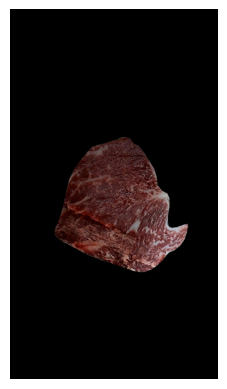

In [17]:
# Visualize a specific image by providing its file path
id = 21 # Replace with the index of the desired image
image_path = test_data['Filepath'][id]
visualize_image(image_path)

In [27]:
!pip install pytorch_pretrained_vit
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00


In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

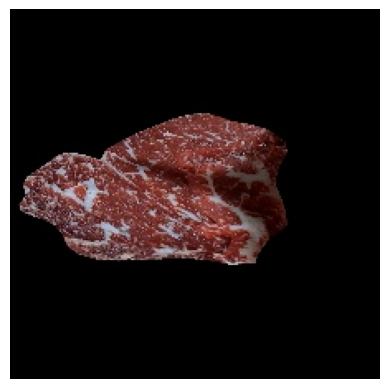

In [122]:
visualize_image(test_data['Filepath'][400])

AttributeError: ignored

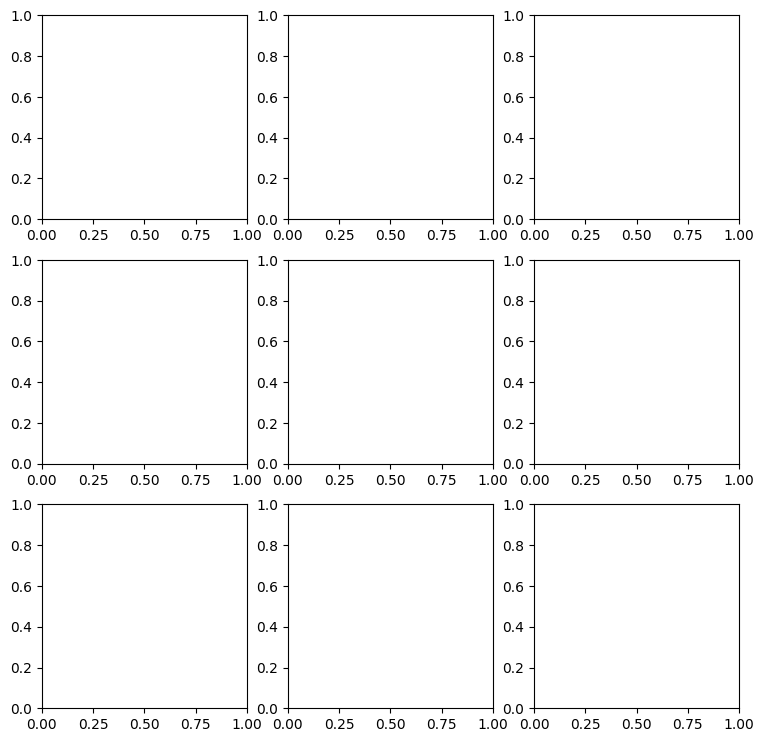

In [95]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

dataset = train_data
# Generate random indices to select random samples from the dataset
random_indices = random.sample(range(len(dataset)), k=9)

# Create a subplot to display the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

# Iterate over the random indices and display the images
for i, index in enumerate(random_indices):
    row = dataset.iloc[index]
    img_path = row['Filepath']
    grade = row['Grade']
    id = row['File ID']

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    row_idx = i // 3
    col_idx = i % 3

    axes[row_idx, col_idx].imshow(image.permute(2, 0, 1))
    axes[row_idx, col_idx].set_title(f"Grade: {grade}, ID:{id}")

plt.tight_layout()
plt.show()


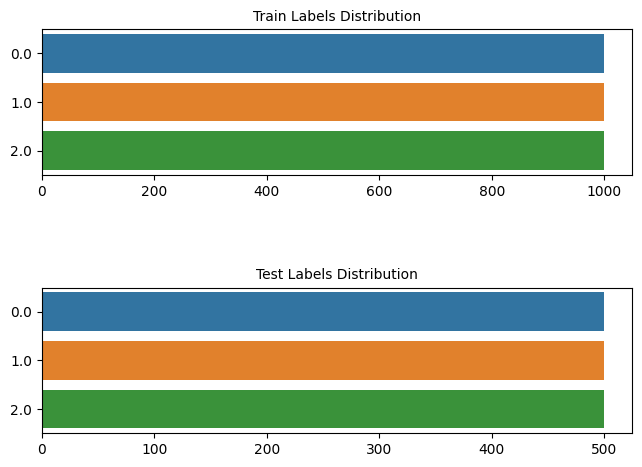

In [112]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=10)
train_distribution = train_data['Grade'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=10)
test_distribution = test_data['Grade'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

In [113]:
class ViT(nn.Module):
    def __init__(self, pretrained = True):
        '''
        This is the constructor for the vision transformer
        '''
        super(ViT, self).__init__()
        model_cfg = dict(drop_path_rate = 0.05, drop_rate = 0.1)
        self.model = timm.create_model('vit_base_patch16_224', pretrained = pretrained, **dict(model_cfg))
        self.model.head = nn.Linear(self.model.head.in_features, 3)

    def forward(self, x):
        x = self.model(x)
        #we apply a softmax on the output of 6 to get the class
        x = F.softmax(x, dim = 1)
        return x


In [130]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import matplotlib.ticker as ticker
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import timm
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torchvision.io import read_image

#Define hyperparameters
batch_size = 32
lr = 5e-5
epochs = 10

In [115]:
from PIL import Image

class CreateImageDataset(Dataset):
    def __init__(self, data, resize_shape=(224, 224), transform=None):
        super().__init__()
        self.data = data
        self.transform = transform
        self.resize_shape = resize_shape


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data['Filepath'].iloc[idx]
        label = self.data['Grade'].iloc[idx]

        image = Image.open(img_path)
        image = image.resize(self.resize_shape, Image.BILINEAR)

        if self.transform:
            image = self.transform(image)

        return image, label



In [125]:
train_data.reset_index(drop=True, inplace=True)  # Reset the index of the train_data DataFrame
test_data.reset_index(drop=True, inplace=True)  # Reset the index of the train_data DataFrame
train_dataset = CreateImageDataset(train_data, transform=transforms.ToTensor())
valid_dataset = CreateImageDataset(test_data, transform=transforms.ToTensor())

In [128]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

cuda


100%|██████████| 47/47 [01:48<00:00,  2.31s/it]


The Validation Loss is 0.9342653652032217 and the validation accuracy is 0.6161644345238095
The Training Loss is 0.9811304972526875 and the training accuracy is 0.5591453094777563


100%|██████████| 47/47 [01:47<00:00,  2.28s/it]


The Validation Loss is 0.9427538439631462 and the validation accuracy is 0.6040736607142857
The Training Loss is 0.945870504734364 and the training accuracy is 0.602580996131528


100%|██████████| 47/47 [01:46<00:00,  2.27s/it]


The Validation Loss is 0.9308383415142695 and the validation accuracy is 0.6158854166666666
The Training Loss is 0.9401364795705105 and the training accuracy is 0.6106745647969053


100%|██████████| 47/47 [01:46<00:00,  2.27s/it]


The Validation Loss is 0.9523853485782942 and the validation accuracy is 0.595889136904762
The Training Loss is 0.9334146431151856 and the training accuracy is 0.6114482591876209


100%|██████████| 47/47 [01:46<00:00,  2.27s/it]


The Validation Loss is 0.8986593907078108 and the validation accuracy is 0.6461123511904762
The Training Loss is 0.9277231782040698 and the training accuracy is 0.6207446808510638


100%|██████████| 47/47 [01:47<00:00,  2.28s/it]


The Validation Loss is 0.8851296330491701 and the validation accuracy is 0.6565290178571429
The Training Loss is 0.8919120735310494 and the training accuracy is 0.6497279980657641


100%|██████████| 47/47 [01:47<00:00,  2.29s/it]


The Validation Loss is 0.9631440738836924 and the validation accuracy is 0.5832403273809524
The Training Loss is 0.8450129640863296 and the training accuracy is 0.7025326402321083


100%|██████████| 47/47 [01:46<00:00,  2.27s/it]


The Validation Loss is 0.8545700535178185 and the validation accuracy is 0.6896391369047619
The Training Loss is 0.865419679499687 and the training accuracy is 0.6767105899419729


100%|██████████| 47/47 [01:47<00:00,  2.29s/it]


The Validation Loss is 0.843390442430973 and the validation accuracy is 0.7039620535714285
The Training Loss is 0.7776672776709211 and the training accuracy is 0.7694028046421664


100%|██████████| 47/47 [01:47<00:00,  2.29s/it]


The Validation Loss is 0.8324916561444601 and the validation accuracy is 0.7144717261904762
The Training Loss is 0.7761411578097241 and the training accuracy is 0.7725580270793038


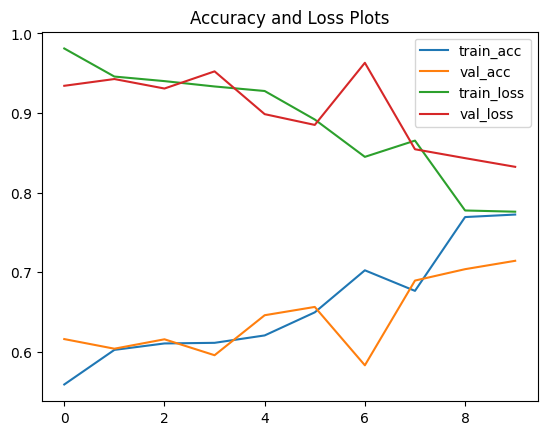

In [131]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = ViT()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5, threshold = 0.001)
train_loss, val_loss, train_acc, val_acc =[], [], [], []
best_acc = 0
for epoch in range(epochs):
    #training
    model.train()
    total_loss, total_correct = 0,0
    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        _, preds = torch.max(output, 1)
        loss = criterion(output, y.long())
        # print("Output")
        # print(output)
        # print("x")
        # print(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # print("Y")
        # print(y.shape)
        # print("preds")
        # print(preds.shape)
        total_correct += torch.sum(preds == y).item()/len(x)
    train_loss.append(total_loss/len(train_dataloader))
    train_acc.append(total_correct/len(train_dataloader))
    # print(total_loss/len(train_dataloader))
    # print(total_correct/len(train_dataloader))

    #validation
    model.eval()
    total_loss, total_correct = 0,0
    with torch.no_grad():
        for x, y in valid_dataloader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, preds = torch.max(output, 1)
            loss = criterion(output, y.long())
            optimizer.zero_grad()
            total_loss += loss.item()
            total_correct += torch.sum(preds == y).item()/len(x)
        val_loss.append(total_loss/len(valid_dataloader))
        val_acc.append(total_correct/len(valid_dataloader))
    scheduler.step(val_loss[-1])

    #saving best model
    if val_acc[-1]>best_acc:
        best_acc = val_acc[-1]
        torch.save({
            'epoch':epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'loss':val_loss[-1],
            'acc':val_acc[-1]
        }, '/content/drive/MyDrive/Colab Notebooks/ViT-aihub/model_checkpoint.pt')
    print('The Validation Loss is {} and the validation accuracy is {}'.format(val_loss[-1],val_acc[-1]))
    print('The Training Loss is {} and the training accuracy is {}'.format(train_loss[-1],train_acc[-1]))

#plot the curves
plt.plot(train_acc, label = 'train_acc')
plt.plot(val_acc, label = 'val_acc')
plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.title('Accuracy and Loss Plots')
plt.show()

